## Using basic Bag of Words features for text mining applications

This notebook is based on the excellent Kaggle tutorial [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words), which details how to use various Python libraries to preprocess text data for NLP tasks like sentiment analysis, document clustering, and the like.  

This preprocessing includes:
- removing all html all tags from each document
- parsing the text of each document (separating it out into individual words)
- removing stop words (words of little meaning like 'and' and 'the')
- stemming (combining words of similar meaning like 'dogs' and 'dog')
- making a word-frequency representations (a.k.a. a Bag of Words feature vector) of a document preprocessed in the manner above

[Click here to view a presentation that graphically illustrates these text preprocessing and transformation steps.](https://drive.google.com/file/d/0B9LZEwqBZcp4RHZ6aW05NmRMMGc/view?usp=sharing)

This notebook also employs the exemplary dataset used in the tutorial - one consisting of movie reviews - labeled as either 'positive' (meaning the person enjoyed the film) or 'negative'.  These reviews are in raw html form (hence the need for tag-stripping etc.,).  

Once all documents are pre-processed (once each movie review is transformed into a Bag of Words feature vector) we can then train a supervised learning model to distinguish between positive and negative reviews.  

In [1]:
# basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# a nice scikit built in pickling library for saving models
from sklearn.externals import joblib

# library for extracting text from HTML files
from bs4 import BeautifulSoup   

# library for stemming, removing stopwords, etc.,
import nltk
nltk.download("stopwords")   # once this download is performed once you need not run it again
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.porter import *
stemmer = PorterStemmer()

# import regular expressions for tokenization
import re

# import scikit learn BoW transformer + classifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Nurgetson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading up and visualizing raw text data

A simple data-loading function comes first - the data here is a raw text document in html format.

In [2]:
# import training data 
def load_data(csvname):
    # load in dataframe
    all_data = pd.read_csv(csvname)

    # grab training data and labels
    data = all_data['review']        
    labels = np.asarray(all_data['sentiment'])

    return data,labels

In [3]:
# load in training data
csvname = "training_data.tsv"
training_data,training_labels = load_data(csvname)

# load in testing data
csvname = "testing_data.tsv"
testing_data,testing_labels = load_data(csvname)

Lets take a quick look at the raw data - notice the many html tags that need removing

In [4]:
# show a raw document from the training set - those from the testing set look the same
training_data[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

## Basic cleaning of text data

Next we clean both the training and testing datasets - this means we

- removing all html all tags from each document
- parsing the text of each document (separating it out into individual words)
- removing stop words (words of little meaning like 'and' and 'the'), punctuation, numbers
- stemming (combining words of similar meaning like 'dogs' and 'dog')

[Click here for a short presentation illustratring these steps graphically.](https://drive.google.com/file/d/0B9LZEwqBZcp4RHZ6aW05NmRMMGc/view?usp=sharing)

These are precisely the actions taken in the next Python cell.

In [5]:
# remove a single document from HTML page, parse, remove stop words, and stem
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)

    # Remove HTML tags (if present)
    review_text = BeautifulSoup(raw_review).get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  

    # Remove stop words 
    meaningful_words = [w for w in words if not w in stops]   

    # Stem the word list - no built in functionality in scikit, although you can directly import the nlkt stemmer
    stemmed_words = [stemmer.stem(word) for word in meaningful_words]

    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( stemmed_words )) 

# clean training dataset
def clean_data(dataset):
    # Get the number of reviews based on the dataframe column size
    num_reviews = dataset.size

    # Initialize an empty list to hold the clean reviews
    cleaned_reviews = []

    # Loop over each review; create an index i that goes from 0 to the length
    # of the movie review list 
    for i in xrange( 0,num_reviews):
        # Call our function for each one, and add the result to the list of
        # clean reviews
        cleaned_reviews.append(review_to_words(dataset[i]))

    # print update
    return cleaned_reviews

In [7]:
# clean training data 
clean_training_data = clean_data(training_data)

# clean testing data
clean_testing_data = clean_data(testing_data)

/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/Nurgetson/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


## Converting cleaned text data to Bag of Words feature vectors

Now that each dataset has been cleaned we can transform the documents from each into Bag of Words features.  Note: we need to create this transformation based on the **training data** alone, as the dictionary (the set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm.  

Hence any future testing data must be transformed in the same way for us to be able to apply the learned training algorithm.

The output of calling the function below will output precisely this Bag of Words transformation.

In [8]:
## convert cleaned, stopword removed, stemmed dataset to BoW features
def make_BoW_transform(train_dataset):
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  Keep only top 5000 most commonly occuring words
    BoW_transform = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 5000) 

    ## Take BoW features from training data - creating a dictionary of words that will also be used on the testing data
    BoW_transform.fit(train_dataset)

    ## save our BoW transform (fit to the training data) so we can use it later to transform future data
    joblib.dump(BoW_transform, 'BoW_transform.pkl') 

    # to load from file use below
    ## BoW_transform = joblib.load('BoW_transform.pkl') # load the BoW transform from file

    # Take a look at the words in the vocabulary
    # vocab = vectorizer.get_feature_names()

    return BoW_transform

In [9]:
# fit a BoW transform to the cleaned documents
BoW_transform = make_BoW_transform(clean_training_data)

With the proper Bag of Words transformation in hand, we transform the (pre-cleaned) training and testing datasets.

In [10]:
# Use the newly formed BoW transformation to transform both training and testing sets
training_BoW_features = BoW_transform.transform(clean_training_data)
training_BoW_features = training_BoW_features.toarray()

testing_BoW_features = BoW_transform.transform(clean_testing_data)
testing_BoW_features = testing_BoW_features.toarray()

Notice that the BoW feature vector has an entry to represent the (normalized) number of each of the words found in the training set documents.  Even after we keep only the 5000 most commonly occuring words, each vector still contains only a fraction of the words found in the joint training set.  This means that BoW feature vectors are quite sparse (most entries are zero).  They are also highly discontinous.

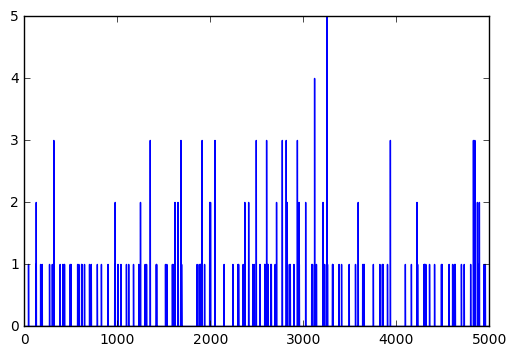

In [16]:
# plot a single (unnormalized) BoW feature vector from the training set - displaying values for only the top 5000 most commonly occuring words in the training set
%matplotlib inline
plt.plot(training_BoW_features[0,:])

In [23]:
# normalize BoW data
import sklearn
training_BoW_features = sklearn.preprocessing.normalize(training_BoW_features,axis = 1)
testing_BoW_features = sklearn.preprocessing.normalize(testing_BoW_features,axis = 1)

##  Classification of BoW text data

Now that the data has all been properly transformed, we can feed it into a nonlinear classifier like e.g., a tree-based algorithm.  These algorithms often work quite well on Bag of Words - their highly discontous and sparse nature is nicely matched by the structure of trees.

In [11]:
# perform classification on training set
def perform_classification(X_train,y_train,X_test,y_test):        
    # load in classifier
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

    # fit classifier to training data
    clf.fit(X_train, y_train)

    # save model
    joblib.dump(clf, 'learned_booster.pkl') 

    # print scores on training and testing sets
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)

    print 'done training boosted classifier'
    print 'accuracy on training set is ' + str(train_accuracy)  
    print 'accuracy on testing set is ' + str(test_accuracy)  

In [24]:
# perform classification on training set, report accuracy on training and testing sets
perform_classification(training_BoW_features,training_labels,testing_BoW_features,testing_labels)

done training boosted classifier
accuracy on training set is 0.847
accuracy on testing set is 0.8234
